### Imports etc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation

In [2]:
%matplotlib inline

# Setup

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
.master("local[*]") \
.appName("spark_setup") \
.getOrCreate()


sc = spark.sparkContext

In [5]:
# read in training data
train_data = spark.read.option("header",True).option("inferSchema",True).csv("train_data")

In [6]:
n_train = train_data.count()
n_train

2200579

In [7]:
train_data.printSchema()

root
 |-- line_str: string (nullable = true)
 |-- resident_status: integer (nullable = true)
 |-- education: integer (nullable = true)
 |-- education_flag: integer (nullable = true)
 |-- death_month: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age_flag: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- age_sub_flag: integer (nullable = true)
 |-- place_of_death: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- death_day_of_week: integer (nullable = true)
 |-- death_year: integer (nullable = true)
 |-- work_injury: string (nullable = true)
 |-- death_manner: integer (nullable = true)
 |-- disposition_method: string (nullable = true)
 |-- autopsy: string (nullable = true)
 |-- activity_code: integer (nullable = true)
 |-- place_of_injury: integer (nullable = true)
 |-- ucd: string (nullable = true)
 |-- ucd_recode_113: integer (nullable = true)
 |-- ucd_recode_39: integer (nullable = true)
 |-- mcd_count_R: integer (nulla

In [8]:
training = train_data.select(["mcd_{}_R".format(x) for x in range(1,21)])

In [9]:
training.show(1)

+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|mcd_1_R|mcd_2_R|mcd_3_R|mcd_4_R|mcd_5_R|mcd_6_R|mcd_7_R|mcd_8_R|mcd_9_R|mcd_10_R|mcd_11_R|mcd_12_R|mcd_13_R|mcd_14_R|mcd_15_R|mcd_16_R|mcd_17_R|mcd_18_R|mcd_19_R|mcd_20_R|
+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|    F03|   R628|   null|   null|   null|   null|   null|   null|   null|    null|    null|    null|    null|    null|    null|    null|    null|    null|    null|    null|
+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
only showing top 1 row



# K-means clustering with three causes of death: 

## Data prep: 

### Selecting the rows that have exactly 3 causes of death: 

In [10]:
training3 = training.where(col('mcd_3_R').isNotNull() & col('mcd_4_R').isNull())

In [11]:
training3.count()

451479

### OHE: 

In [12]:
for x in range(1,4):
    # for each level, count freq. val=0 for most freq, then 1, ...
    stringIndexer = StringIndexer(inputCol="mcd_{}_R".format(x), outputCol="mcd_{}_index".format(x))
    model = stringIndexer.fit(training3)
    training3 = model.transform(training3)

In [13]:
training3.show(2)

+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----------+-----------+-----------+
|mcd_1_R|mcd_2_R|mcd_3_R|mcd_4_R|mcd_5_R|mcd_6_R|mcd_7_R|mcd_8_R|mcd_9_R|mcd_10_R|mcd_11_R|mcd_12_R|mcd_13_R|mcd_14_R|mcd_15_R|mcd_16_R|mcd_17_R|mcd_18_R|mcd_19_R|mcd_20_R|mcd_1_index|mcd_2_index|mcd_3_index|
+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----------+-----------+-----------+
|   J449|   F179|   J969|   null|   null|   null|   null|   null|   null|    null|    null|    null|    null|    null|    null|    null|    null|    null|    null|    null|        2.0|        0.0|        1.0|
|   C259|   C780|   C787|   null|   null|   null|   null|   null|   null|    null|    null|    null|    null|    null|    null|    null|    null|    null|    null| 

In [84]:
indexed3 = training3.select(["mcd_{}_R".format(x) for x in range(1,4)]+["mcd_{}_index".format(x) for x in range(1,4)])

In [85]:
indexed3.show(5)

+-------+-------+-------+-----------+-----------+-----------+
|mcd_1_R|mcd_2_R|mcd_3_R|mcd_1_index|mcd_2_index|mcd_3_index|
+-------+-------+-------+-----------+-----------+-----------+
|   J449|   F179|   J969|        2.0|        0.0|        1.0|
|   C259|   C780|   C787|       21.0|       17.0|       51.0|
|   F102|   F179|   K922|      100.0|        0.0|       31.0|
|   I499|    I10|   J449|       75.0|        2.0|        5.0|
|   C349|   F179|   I469|        1.0|        0.0|        0.0|
+-------+-------+-------+-----------+-----------+-----------+
only showing top 5 rows



In [86]:
assembler = VectorAssembler(
    inputCols=['mcd_{}_index'.format(x) for x in range(1,4)],
    outputCol="features")

mcd_3_train = assembler.transform(indexed3)

In [87]:
mcd_3_train.show(5)

+-------+-------+-------+-----------+-----------+-----------+----------------+
|mcd_1_R|mcd_2_R|mcd_3_R|mcd_1_index|mcd_2_index|mcd_3_index|        features|
+-------+-------+-------+-----------+-----------+-----------+----------------+
|   J449|   F179|   J969|        2.0|        0.0|        1.0|   [2.0,0.0,1.0]|
|   C259|   C780|   C787|       21.0|       17.0|       51.0|[21.0,17.0,51.0]|
|   F102|   F179|   K922|      100.0|        0.0|       31.0|[100.0,0.0,31.0]|
|   I499|    I10|   J449|       75.0|        2.0|        5.0|  [75.0,2.0,5.0]|
|   C349|   F179|   I469|        1.0|        0.0|        0.0|   [1.0,0.0,0.0]|
+-------+-------+-------+-----------+-----------+-----------+----------------+
only showing top 5 rows



## Model selection: 

In [23]:
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(mcd_3_train.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(mcd_3_train) # requires Spark 2.0 or later
    print("Done training k=", k)

Done training k= 2
Done training k= 3
Done training k= 4
Done training k= 5
Done training k= 6
Done training k= 7
Done training k= 8
Done training k= 9
Done training k= 10
Done training k= 11
Done training k= 12
Done training k= 13
Done training k= 14
Done training k= 15
Done training k= 16
Done training k= 17
Done training k= 18
Done training k= 19


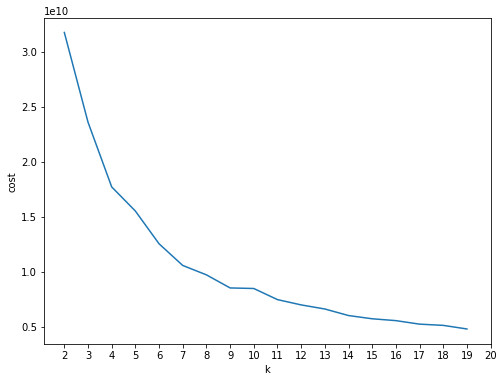

In [24]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ticks = [x for x in range(2,21)]
ax.set_xticks(ticks=ticks)

Choose k=6 & k=9, maybe? 

## Fitting k=9: 

In [26]:
# Trains a k-means model.
kmeans_9 = KMeans().setK(9).setSeed(1)
model_9 = kmeans_9.fit(mcd_3_train)

In [27]:
# Make predictions
predictions_9 = model_9.transform(mcd_3_train)

In [28]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

In [29]:
silhouette = evaluator.evaluate(predictions_9)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.7419485614439529


In [30]:
# Shows the result.
centers = model_9.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[30.13050646 20.31333428 28.78490602]
[312.86414017  44.80513802  48.45188424]
[ 248.63885899  201.01345533 1387.39289559]
[1752.60496381  177.87107894  196.22578421]
[125.16326291 710.79213615 113.01631455]
[ 252.17306843 1577.81059603  239.7183223 ]
[ 83.08668399  67.71670998 440.32681038]
[846.8099602  102.84717208 106.59483477]
[ 52.08247039 239.41867675  50.27271036]


## Visualizing: 

In [31]:
preds_9 = predictions_9.select("*").withColumn("id", monotonically_increasing_id()).drop('features')
preds_9.show(5)

+-----------+-----------+-----------+----------+---+
|mcd_1_index|mcd_2_index|mcd_3_index|prediction| id|
+-----------+-----------+-----------+----------+---+
|        2.0|        0.0|        1.0|         0|  0|
|       21.0|       17.0|       51.0|         0|  1|
|      100.0|        0.0|       31.0|         0|  2|
|       75.0|        2.0|        5.0|         0|  3|
|        1.0|        0.0|        0.0|         0|  4|
+-----------+-----------+-----------+----------+---+
only showing top 5 rows



In [32]:
pddf_pred_9 = preds_9.toPandas().set_index('id')
pddf_pred_9.head()

,mcd_1_index,mcd_2_index,mcd_3_index,prediction
id,,,,
0,2.0,0.0,1.0,0
1,21.0,17.0,51.0,0
2,100.0,0.0,31.0,0
3,75.0,2.0,5.0,0
4,1.0,0.0,0.0,0


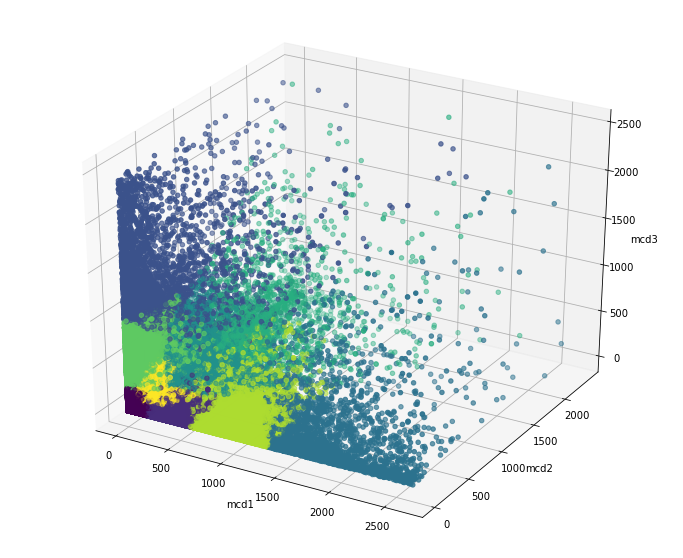

In [33]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pddf_pred_9.mcd_1_index, pddf_pred_9.mcd_2_index, pddf_pred_9.mcd_3_index, c=pddf_pred_9.prediction)
threedee.set_xlabel('mcd1')
threedee.set_ylabel('mcd2')
threedee.set_zlabel('mcd3')
plt.show()

## k=6:

In [88]:
# Trains a k-means model.
kmeans_6 = KMeans().setK(6).setSeed(1)
model_6 = kmeans_6.fit(mcd_3_train)
# Make predictions
predictions_6 = model_6.transform(mcd_3_train)
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions_6)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.8192637805648658


In [89]:
# Shows the result.
centers = model_6.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[38.71350853 37.13920011 30.04491799]
[498.33021974  76.03881785  67.64975882]
[ 86.11863783  87.30754717 424.77722043]
[1429.15062479  162.36761229  164.41827085]
[ 255.8318084   225.03229279 1397.49757804]
[136.49846297 884.07983232 121.41043316]


In [90]:
preds_6 = predictions_6.select("*").withColumn("id", monotonically_increasing_id()).drop('features')
pddf_pred_6 = preds_6.toPandas().set_index('id')
pddf_pred_6.head()

,mcd_1_R,mcd_2_R,mcd_3_R,mcd_1_index,mcd_2_index,mcd_3_index,prediction
id,,,,,,,
0,J449,F179,J969,2.0,0.0,1.0,0
1,C259,C780,C787,21.0,17.0,51.0,0
2,F102,F179,K922,100.0,0.0,31.0,0
3,I499,I10,J449,75.0,2.0,5.0,0
4,C349,F179,I469,1.0,0.0,0.0,0


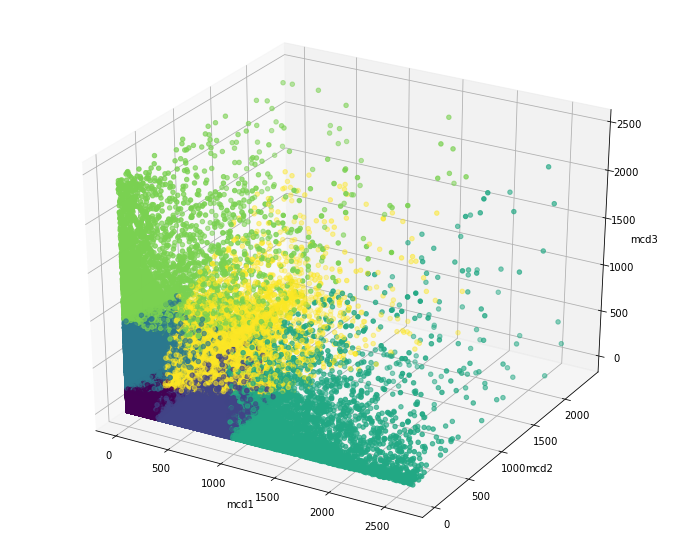

In [38]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pddf_pred_6.mcd_1_index, pddf_pred_6.mcd_2_index, pddf_pred_6.mcd_3_index, c=pddf_pred_6.prediction)
threedee.set_xlabel('mcd1')
threedee.set_ylabel('mcd2')
threedee.set_zlabel('mcd3')
plt.show()

In [65]:
#pddf_pred_6.to_csv('export/mcod3_k5.csv')

# Training using recoded data:

In [39]:
training3.show(2)

+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----------+-----------+-----------+
|mcd_1_R|mcd_2_R|mcd_3_R|mcd_4_R|mcd_5_R|mcd_6_R|mcd_7_R|mcd_8_R|mcd_9_R|mcd_10_R|mcd_11_R|mcd_12_R|mcd_13_R|mcd_14_R|mcd_15_R|mcd_16_R|mcd_17_R|mcd_18_R|mcd_19_R|mcd_20_R|mcd_1_index|mcd_2_index|mcd_3_index|
+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----------+-----------+-----------+
|   J449|   F179|   J969|   null|   null|   null|   null|   null|   null|    null|    null|    null|    null|    null|    null|    null|    null|    null|    null|    null|        2.0|        0.0|        1.0|
|   C259|   C780|   C787|   null|   null|   null|   null|   null|   null|    null|    null|    null|    null|    null|    null|    null|    null|    null|    null| 

In [40]:
training3_R = training3.select(["mcd_{}_R".format(x) for x in range(1,4)])

In [41]:
training3_R.show(2)

+-------+-------+-------+
|mcd_1_R|mcd_2_R|mcd_3_R|
+-------+-------+-------+
|   J449|   F179|   J969|
|   C259|   C780|   C787|
+-------+-------+-------+
only showing top 2 rows



In [42]:
# strip UCD codes to include first letter only
training3_R = training3_R.withColumn("ucd_short_1", regexp_replace('mcd_1_R', '\\d+', '')) \
                        .withColumn("ucd_short_2", regexp_replace('mcd_2_R', '\\d+', '')) \
                        .withColumn("ucd_short_3", regexp_replace('mcd_3_R', '\\d+', ''))


In [43]:
training3_R.show(2)

+-------+-------+-------+-----------+-----------+-----------+
|mcd_1_R|mcd_2_R|mcd_3_R|ucd_short_1|ucd_short_2|ucd_short_3|
+-------+-------+-------+-----------+-----------+-----------+
|   J449|   F179|   J969|          J|          F|          J|
|   C259|   C780|   C787|          C|          C|          C|
+-------+-------+-------+-----------+-----------+-----------+
only showing top 2 rows



In [44]:
# One-hot encoding:
for x in range(1,4):
    # for each level, count freq. val=0 for most freq, then 1, ...
    stringIndexer = StringIndexer(inputCol="ucd_short_{}".format(x), outputCol="mcd_{}_index".format(x))
    model = stringIndexer.fit(training3_R)
    training3_R = model.transform(training3_R)

In [45]:
training3_R.show(2)

+-------+-------+-------+-----------+-----------+-----------+-----------+-----------+-----------+
|mcd_1_R|mcd_2_R|mcd_3_R|ucd_short_1|ucd_short_2|ucd_short_3|mcd_1_index|mcd_2_index|mcd_3_index|
+-------+-------+-------+-----------+-----------+-----------+-----------+-----------+-----------+
|   J449|   F179|   J969|          J|          F|          J|        2.0|        1.0|        1.0|
|   C259|   C780|   C787|          C|          C|          C|        1.0|        5.0|        8.0|
+-------+-------+-------+-----------+-----------+-----------+-----------+-----------+-----------+
only showing top 2 rows



In [46]:
assembler = VectorAssembler(
    inputCols=['mcd_{}_index'.format(x) for x in range(1,4)],
    outputCol="features")

mcd_3R_train = assembler.transform(training3_R)

In [47]:
mcd_3R_train.show(2)

+-------+-------+-------+-----------+-----------+-----------+-----------+-----------+-----------+-------------+
|mcd_1_R|mcd_2_R|mcd_3_R|ucd_short_1|ucd_short_2|ucd_short_3|mcd_1_index|mcd_2_index|mcd_3_index|     features|
+-------+-------+-------+-----------+-----------+-----------+-----------+-----------+-----------+-------------+
|   J449|   F179|   J969|          J|          F|          J|        2.0|        1.0|        1.0|[2.0,1.0,1.0]|
|   C259|   C780|   C787|          C|          C|          C|        1.0|        5.0|        8.0|[1.0,5.0,8.0]|
+-------+-------+-------+-----------+-----------+-----------+-----------+-----------+-----------+-------------+
only showing top 2 rows



In [54]:
mcd_3R_train.select('ucd_short_1').distinct().count()

23

In [55]:
cost = np.zeros(11)
for k in range(2,11):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(mcd_3R_train.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(mcd_3R_train)
    print("Done training k=", k)

Done training k= 2
Done training k= 3
Done training k= 4
Done training k= 5
Done training k= 6
Done training k= 7
Done training k= 8
Done training k= 9
Done training k= 10


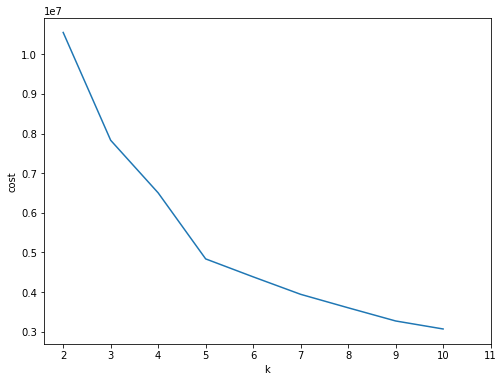

In [56]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),cost[2:11])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ticks = [x for x in range(2,12)]
ax.set_xticks(ticks=ticks)

Use k=5.

In [57]:
# Trains a k-means model.
kmeans_5R = KMeans().setK(5).setSeed(1)
model_5R = kmeans.fit(mcd_3R_train)
# Make predictions
predictions_5R = model_5R.transform(mcd_3R_train)
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions_5R)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.5244206721989629


In [58]:
preds_5R = predictions_5R.select("*").withColumn("id", monotonically_increasing_id()).drop('features')
pddf_pred_5R = preds_5R.toPandas().set_index('id')
pddf_pred_5R.head()

,mcd_1_R,mcd_2_R,mcd_3_R,ucd_short_1,ucd_short_2,ucd_short_3,mcd_1_index,mcd_2_index,mcd_3_index,prediction
id,,,,,,,,,,
0,J449,F179,J969,J,F,J,2.0,1.0,1.0,1
1,C259,C780,C787,C,C,C,1.0,5.0,8.0,3
2,F102,F179,K922,F,F,K,6.0,1.0,5.0,2
3,I499,I10,J449,I,I,J,0.0,0.0,1.0,1
4,C349,F179,I469,C,F,I,1.0,1.0,0.0,1


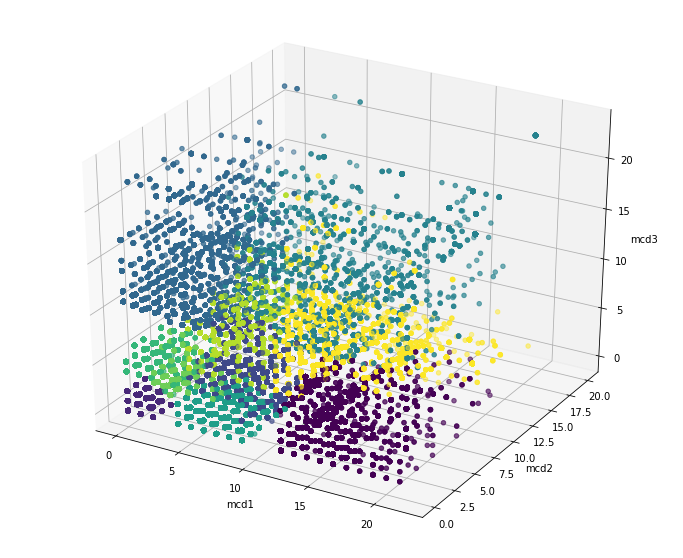

In [59]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pddf_pred_5R.mcd_1_index, pddf_pred_5R.mcd_2_index, pddf_pred_5R.mcd_3_index, c=pddf_pred_5R.prediction)
threedee.set_xlabel('mcd1')
threedee.set_ylabel('mcd2')
threedee.set_zlabel('mcd3')
plt.show()

# Using the 2nd, 3rd, & 4th CODs to try to find the main COD

## Data prep:

In [64]:
# Selecting rows that have only 4 CODs:
training4 = training.where(col('mcd_4_R').isNotNull() & col('mcd_5_R').isNull())

# OHE: 
for x in range(1,5):
    # for each level, count freq. val=0 for most freq, then 1, ...
    stringIndexer = StringIndexer(inputCol="mcd_{}_R".format(x), outputCol="mcd_{}_index".format(x))
    model = stringIndexer.fit(training4)
    training4 = model.transform(training4)
    
# indexing: 
indexed4 = training4.select(["mcd_{}_R".format(x) for x in range(1,5)]+["mcd_{}_index".format(x) for x in range(1,5)])

In [65]:
indexed4.show(5)

+-------+-------+-------+-------+-----------+-----------+-----------+-----------+
|mcd_1_R|mcd_2_R|mcd_3_R|mcd_4_R|mcd_1_index|mcd_2_index|mcd_3_index|mcd_4_index|
+-------+-------+-------+-------+-----------+-----------+-----------+-----------+
|    I64|   I120|   N185|   Q909|        6.0|       19.0|       54.0|      234.0|
|   I120|    I48|   I500|    I64|       41.0|       10.0|        2.0|       15.0|
|   J189|   E149|    I10|   J969|       10.0|        3.0|        0.0|        1.0|
|   C833|   D619|   K729|    N19|      141.0|       82.0|       29.0|       17.0|
|   I609|   I251|   I469|   K579|      110.0|        7.0|        1.0|      259.0|
+-------+-------+-------+-------+-----------+-----------+-----------+-----------+
only showing top 5 rows



In [67]:
# creating a "features" column using only the 2nd, 3rd, & 4th CODs
assembler = VectorAssembler(
    inputCols=['mcd_{}_index'.format(x) for x in range(2,5)],
    outputCol="features")

mcd_1_train = assembler.transform(indexed4)

In [68]:
mcd_1_train.show(2)

+-------+-------+-------+-------+-----------+-----------+-----------+-----------+-----------------+
|mcd_1_R|mcd_2_R|mcd_3_R|mcd_4_R|mcd_1_index|mcd_2_index|mcd_3_index|mcd_4_index|         features|
+-------+-------+-------+-------+-----------+-----------+-----------+-----------+-----------------+
|    I64|   I120|   N185|   Q909|        6.0|       19.0|       54.0|      234.0|[19.0,54.0,234.0]|
|   I120|    I48|   I500|    I64|       41.0|       10.0|        2.0|       15.0|  [10.0,2.0,15.0]|
+-------+-------+-------+-------+-----------+-----------+-----------+-----------+-----------------+
only showing top 2 rows



## Fitting k=23 because that's how many recodes we have: 

In [69]:
# Trains a k-means model.
kmeans_23R = KMeans().setK(23).setSeed(1)
model_23R = kmeans_23R.fit(mcd_1_train)
# Make predictions
predictions_23R = model_23R.transform(mcd_1_train)
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions_23R)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.6106807199395289


In [75]:
# indexing the recoded primary COD:
mcd_1_preds = predictions_23R.withColumn("ucd_short_1", regexp_replace('mcd_1_R', '\\d+', '')).select(['mcd_1_R', 'mcd_1_index', 'prediction', 'ucd_short_1'])
stringIndexer = StringIndexer(inputCol="ucd_short_1", outputCol="short_index")
model = stringIndexer.fit(mcd_1_preds)
mcd_1_preds = model.transform(mcd_1_preds)
mcd_1_preds.show(5)

+-------+-----------+----------+-----------+-----------+
|mcd_1_R|mcd_1_index|prediction|ucd_short_1|short_index|
+-------+-----------+----------+-----------+-----------+
|    I64|        6.0|         7|          I|        0.0|
|   I120|       41.0|        13|          I|        0.0|
|   J189|       10.0|        13|          J|        2.0|
|   C833|      141.0|        13|          C|        1.0|
|   I609|      110.0|         7|          I|        0.0|
+-------+-----------+----------+-----------+-----------+
only showing top 5 rows



In [76]:
# creating a "features" column to calculate the correlation over:
assembler = VectorAssembler(
    inputCols=['prediction', 'short_index'],
    outputCol="features")

mcd_1_preds = assembler.transform(mcd_1_preds)

## Calculating the correlation: 

In [77]:
r1 = Correlation.corr(mcd_1_preds, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

Pearson correlation matrix:
DenseMatrix([[ 1.        , -0.05779331],
             [-0.05779331,  1.        ]])


:( 

In [79]:
#mcd_1_preds.groupby("prediction", "ucd_short_1").agg(F.count("ucd_short_1")).orderBy(asc("prediction"), desc("count(ucd_short_1)")).show(25)

In [80]:
# Register the DataFrame as a SQL temporary view
mcd_1_preds.createOrReplaceTempView("mcd_1")

In [81]:
sqlDF = spark.sql("""SELECT prediction, ucd_short_1, count(ucd_short_1) as N
                            FROM mcd_1 
                            GROUP BY prediction, ucd_short_1
                            ORDER BY prediction, N DESC""")
sqlDF.show(25)

+----------+-----------+----+
|prediction|ucd_short_1|   N|
+----------+-----------+----+
|         0|          I|6389|
|         0|          C|2742|
|         0|          J|1844|
|         0|          X|1541|
|         0|          G|1489|
|         0|          E|1396|
|         0|          F|1300|
|         0|          K|1038|
|         0|          W| 765|
|         0|          A| 701|
|         0|          N| 641|
|         0|          V| 617|
|         0|          B| 350|
|         0|          D| 284|
|         0|          M| 162|
|         0|          Y| 145|
|         0|          Q|  62|
|         0|          L|  31|
|         0|          R|  16|
|         0|          P|  10|
|         0|          O|   4|
|         1|          I| 831|
|         1|          C| 599|
|         1|          J| 270|
|         1|          K| 267|
+----------+-----------+----+
only showing top 25 rows



In [82]:
# pivoted = (sqlDF
#     .groupBy("prediction")
#     .pivot(
#         "ucd_short_1") 
#     .agg(F.count("ucd_short_1"))) 
# pivoted.show()

# Analyzing the k=6, non-recoded results: 

In [92]:
preds_6R = predictions_6.drop('features') \
                        .withColumn("ucd_short_1", regexp_replace('mcd_1_R', '\\d+', '')) \
                        .withColumn("ucd_short_2", regexp_replace('mcd_2_R', '\\d+', '')) \
                        .withColumn("ucd_short_3", regexp_replace('mcd_3_R', '\\d+', ''))

In [93]:
preds_6R.show(5)

+-------+-------+-------+-----------+-----------+-----------+----------+-----------+-----------+-----------+
|mcd_1_R|mcd_2_R|mcd_3_R|mcd_1_index|mcd_2_index|mcd_3_index|prediction|ucd_short_1|ucd_short_2|ucd_short_3|
+-------+-------+-------+-----------+-----------+-----------+----------+-----------+-----------+-----------+
|   J449|   F179|   J969|        2.0|        0.0|        1.0|         0|          J|          F|          J|
|   C259|   C780|   C787|       21.0|       17.0|       51.0|         0|          C|          C|          C|
|   F102|   F179|   K922|      100.0|        0.0|       31.0|         0|          F|          F|          K|
|   I499|    I10|   J449|       75.0|        2.0|        5.0|         0|          I|          I|          J|
|   C349|   F179|   I469|        1.0|        0.0|        0.0|         0|          C|          F|          I|
+-------+-------+-------+-----------+-----------+-----------+----------+-----------+-----------+-----------+
only showing top 5 

In [94]:
preds_6RR = preds_6R.drop('mcd_1_R', 'mcd_2_R', 'mcd_3_R', 'mcd_1_index', 'mcd_2_index', 'mcd_3_index')

In [95]:
preds_6RR.show(5)

+----------+-----------+-----------+-----------+
|prediction|ucd_short_1|ucd_short_2|ucd_short_3|
+----------+-----------+-----------+-----------+
|         0|          J|          F|          J|
|         0|          C|          C|          C|
|         0|          F|          F|          K|
|         0|          I|          I|          J|
|         0|          C|          F|          I|
+----------+-----------+-----------+-----------+
only showing top 5 rows



In [97]:
preds_6RR.createOrReplaceTempView('preds_6R')

## Looking at the distribution of each cluster's primary COD

In [133]:
sqlDF_0 = spark.sql("""SELECT prediction, ucd_short_1, count(ucd_short_1) as N
                            FROM preds_6R 
                            WHERE prediction = 0
                            GROUP BY prediction, ucd_short_1
                            ORDER BY prediction, N DESC""")
sqlDF_0.show()

+----------+-----------+------+
|prediction|ucd_short_1|     N|
+----------+-----------+------+
|         0|          I|130597|
|         0|          C| 63549|
|         0|          J| 44987|
|         0|          X| 30711|
|         0|          G| 24391|
|         0|          E| 22351|
|         0|          F| 20606|
|         0|          K| 12388|
|         0|          N| 10953|
|         0|          A|  7775|
|         0|          W|  5095|
|         0|          V|  3382|
|         0|          D|  2024|
|         0|          B|  1381|
|         0|          Y|  1053|
|         0|          M|   793|
|         0|          L|   386|
|         0|          Q|   381|
|         0|          R|   195|
+----------+-----------+------+



In [134]:
sqlDF_1 = spark.sql("""SELECT prediction, ucd_short_1, count(ucd_short_1) as N
                            FROM preds_6R 
                            WHERE prediction = 1
                            GROUP BY prediction, ucd_short_1
                            ORDER BY prediction, N DESC""")
sqlDF_1.show()

+----------+-----------+----+
|prediction|ucd_short_1|   N|
+----------+-----------+----+
|         1|          C|3698|
|         1|          I|3566|
|         1|          K|2932|
|         1|          V|1484|
|         1|          G|1418|
|         1|          W|1387|
|         1|          D|1380|
|         1|          J|1355|
|         1|          E|1316|
|         1|          M|1121|
|         1|          B| 936|
|         1|          F| 827|
|         1|          N| 702|
|         1|          R| 686|
|         1|          A| 674|
|         1|          Q| 621|
|         1|          Y| 620|
|         1|          X| 532|
|         1|          L| 416|
|         1|          P| 388|
+----------+-----------+----+



In [135]:
sqlDF_2 = spark.sql("""SELECT prediction, ucd_short_1, count(ucd_short_1) as N
                            FROM preds_6R 
                            WHERE prediction = 2
                            GROUP BY prediction, ucd_short_1
                            ORDER BY prediction, N DESC""")
sqlDF_2.show()

+----------+-----------+----+
|prediction|ucd_short_1|   N|
+----------+-----------+----+
|         2|          C|5441|
|         2|          I|5095|
|         2|          J|1622|
|         2|          X|1445|
|         2|          G|1348|
|         2|          K|1336|
|         2|          E|1028|
|         2|          F| 873|
|         2|          W| 778|
|         2|          N| 704|
|         2|          Y| 535|
|         2|          A| 534|
|         2|          V| 342|
|         2|          D| 230|
|         2|          M| 191|
|         2|          B| 162|
|         2|          Q| 144|
|         2|          P| 106|
|         2|          L|  77|
|         2|          R|  17|
+----------+-----------+----+



In [136]:
sqlDF_3 = spark.sql("""SELECT prediction, ucd_short_1, count(ucd_short_1) as N
                            FROM preds_6R 
                            WHERE prediction = 3
                            GROUP BY prediction, ucd_short_1
                            ORDER BY prediction, N DESC""")
sqlDF_3.show()

+----------+-----------+---+
|prediction|ucd_short_1|  N|
+----------+-----------+---+
|         3|          C|611|
|         3|          I|541|
|         3|          K|458|
|         3|          V|450|
|         3|          Q|449|
|         3|          D|415|
|         3|          G|318|
|         3|          P|283|
|         3|          J|266|
|         3|          E|261|
|         3|          M|259|
|         3|          N|256|
|         3|          B|220|
|         3|          F|183|
|         3|          R|181|
|         3|          A|177|
|         3|          Y|177|
|         3|          X|117|
|         3|          W|110|
|         3|          L| 88|
+----------+-----------+---+
only showing top 20 rows



In [137]:
sqlDF_4 = spark.sql("""SELECT prediction, ucd_short_1, count(ucd_short_1) as N
                            FROM preds_6R 
                            WHERE prediction = 4
                            GROUP BY prediction, ucd_short_1
                            ORDER BY prediction, N DESC""")
sqlDF_4.show()

+----------+-----------+---+
|prediction|ucd_short_1|  N|
+----------+-----------+---+
|         4|          C|804|
|         4|          I|691|
|         4|          X|276|
|         4|          J|206|
|         4|          G|205|
|         4|          K|205|
|         4|          Q|178|
|         4|          P|170|
|         4|          Y|157|
|         4|          W|142|
|         4|          E|126|
|         4|          F|125|
|         4|          A| 99|
|         4|          B| 87|
|         4|          N| 72|
|         4|          V| 65|
|         4|          D| 61|
|         4|          M| 44|
|         4|          R| 24|
|         4|          L| 23|
+----------+-----------+---+
only showing top 20 rows



In [138]:
sqlDF_5 = spark.sql("""SELECT prediction, ucd_short_1, count(ucd_short_1) as N
                            FROM preds_6R 
                            WHERE prediction = 5
                            GROUP BY prediction, ucd_short_1
                            ORDER BY prediction, N DESC""")
sqlDF_5.show()

+----------+-----------+----+
|prediction|ucd_short_1|   N|
+----------+-----------+----+
|         5|          I|2416|
|         5|          C|2052|
|         5|          G| 825|
|         5|          J| 770|
|         5|          X| 716|
|         5|          K| 642|
|         5|          F| 590|
|         5|          E| 413|
|         5|          W| 404|
|         5|          A| 311|
|         5|          V| 282|
|         5|          N| 233|
|         5|          D| 199|
|         5|          B| 194|
|         5|          Y| 188|
|         5|          Q| 165|
|         5|          P| 163|
|         5|          M| 107|
|         5|          L|  27|
|         5|          R|  20|
+----------+-----------+----+
only showing top 20 rows



In [140]:
df0 = sqlDF_0.toPandas()
df1 = sqlDF_1.toPandas()
df2 = sqlDF_2.toPandas()
df3 = sqlDF_3.toPandas()
df4 = sqlDF_4.toPandas()
df5 = sqlDF_5.toPandas()

In [143]:
pdList = [df0, df1, df2, df3, df4, df5]  # List of your dataframes
concat_df = pd.concat(pdList)
concat_df.to_csv('k6_dists_ucd1.csv', index=False)

## Exporting the distribution of all of the CODs 

In [146]:
sqlDF_0a = spark.sql("""SELECT prediction, ucd_short_1, ucd_short_2, ucd_short_3, count(prediction) as N
                            FROM preds_6R 
                            WHERE prediction = 0
                            GROUP BY prediction, ucd_short_1, ucd_short_2, ucd_short_3
                            ORDER BY N DESC""")
sqlDF_1a = spark.sql("""SELECT prediction, ucd_short_1, ucd_short_2, ucd_short_3, count(prediction) as N
                            FROM preds_6R 
                            WHERE prediction = 1
                            GROUP BY prediction, ucd_short_1, ucd_short_2, ucd_short_3
                            ORDER BY N DESC""")
sqlDF_2a = spark.sql("""SELECT prediction, ucd_short_1, ucd_short_2, ucd_short_3, count(prediction) as N
                            FROM preds_6R 
                            WHERE prediction = 2
                            GROUP BY prediction, ucd_short_1, ucd_short_2, ucd_short_3
                            ORDER BY N DESC""")
sqlDF_3a = spark.sql("""SELECT prediction, ucd_short_1, ucd_short_2, ucd_short_3, count(prediction) as N
                            FROM preds_6R 
                            WHERE prediction = 3
                            GROUP BY prediction, ucd_short_1, ucd_short_2, ucd_short_3
                            ORDER BY N DESC""")
sqlDF_4a = spark.sql("""SELECT prediction, ucd_short_1, ucd_short_2, ucd_short_3, count(prediction) as N
                            FROM preds_6R 
                            WHERE prediction = 4
                            GROUP BY prediction, ucd_short_1, ucd_short_2, ucd_short_3
                            ORDER BY N DESC""")
sqlDF_5a = spark.sql("""SELECT prediction, ucd_short_1, ucd_short_2, ucd_short_3, count(prediction) as N
                            FROM preds_6R 
                            WHERE prediction = 5
                            GROUP BY prediction, ucd_short_1, ucd_short_2, ucd_short_3
                            ORDER BY N DESC""")

In [147]:
df0a = sqlDF_0a.toPandas()
df1a = sqlDF_1a.toPandas()
df2a = sqlDF_2a.toPandas()
df3a = sqlDF_3a.toPandas()
df4a = sqlDF_4a.toPandas()
df5a = sqlDF_5a.toPandas()

In [148]:
pdList = [df0a, df1a, df2a, df3a, df4a, df5a]  # List of your dataframes
concat_df = pd.concat(pdList)
concat_df.to_csv('k6_dists.csv', index=False)

## Looking at some other representations of the data

In [115]:
sqlDF = spark.sql("""SELECT prediction, ucd_short_1, count(prediction) as N
                            FROM preds_6R 
                            WHERE ucd_short_1 = 'C'
                            GROUP BY ucd_short_1, prediction
                            ORDER BY N DESC""")
sqlDF.show(10)

+----------+-----------+-----+
|prediction|ucd_short_1|    N|
+----------+-----------+-----+
|         0|          C|63549|
|         2|          C| 5441|
|         1|          C| 3698|
|         5|          C| 2052|
|         4|          C|  804|
|         3|          C|  611|
+----------+-----------+-----+



In [116]:
sqlDF = spark.sql("""SELECT prediction, ucd_short_1, count(prediction) as N
                            FROM preds_6R 
                            WHERE ucd_short_1 = 'I'
                            GROUP BY ucd_short_1, prediction
                            ORDER BY N DESC""")
sqlDF.show()

+----------+-----------+------+
|prediction|ucd_short_1|     N|
+----------+-----------+------+
|         0|          I|130597|
|         2|          I|  5095|
|         1|          I|  3566|
|         5|          I|  2416|
|         4|          I|   691|
|         3|          I|   541|
+----------+-----------+------+



In [117]:
sqlDF = spark.sql("""SELECT prediction, ucd_short_1, count(prediction) as N
                            FROM preds_6R 
                            WHERE ucd_short_1 = 'R'
                            GROUP BY ucd_short_1, prediction
                            ORDER BY N DESC""")
sqlDF.show(10)

+----------+-----------+---+
|prediction|ucd_short_1|  N|
+----------+-----------+---+
|         1|          R|686|
|         0|          R|195|
|         3|          R|181|
|         4|          R| 24|
|         5|          R| 20|
|         2|          R| 17|
+----------+-----------+---+



In [127]:
sqlDF = spark.sql("""SELECT prediction, ucd_short_1, count(ucd_short_1) as N
                            FROM preds_6R 
                            WHERE prediction = 5
                            GROUP BY prediction, ucd_short_1
                            ORDER BY prediction, N DESC""")
sqlDF.show()

+----------+-----------+----+
|prediction|ucd_short_1|   N|
+----------+-----------+----+
|         5|          I|2416|
|         5|          C|2052|
|         5|          G| 825|
|         5|          J| 770|
|         5|          X| 716|
|         5|          K| 642|
|         5|          F| 590|
|         5|          E| 413|
|         5|          W| 404|
|         5|          A| 311|
|         5|          V| 282|
|         5|          N| 233|
|         5|          D| 199|
|         5|          B| 194|
|         5|          Y| 188|
|         5|          Q| 165|
|         5|          P| 163|
|         5|          M| 107|
|         5|          L|  27|
|         5|          R|  20|
+----------+-----------+----+
only showing top 20 rows



In [128]:
sqlDF = spark.sql("""SELECT prediction, ucd_short_1, count(prediction) as N
                            FROM preds_6R 
                            WHERE ucd_short_1 = 'X'
                            GROUP BY ucd_short_1, prediction
                            ORDER BY N DESC""")
sqlDF.show()

+----------+-----------+-----+
|prediction|ucd_short_1|    N|
+----------+-----------+-----+
|         0|          X|30711|
|         2|          X| 1445|
|         5|          X|  716|
|         1|          X|  532|
|         4|          X|  276|
|         3|          X|  117|
+----------+-----------+-----+

